# 연면적 및 주거전용면적 전체 동수 결측치 채워 머신러닝 돌려보기 

In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

In [2]:
origin_test_path ="../../data/test.csv"
origin_train_path = "../../data/train.csv"

In [3]:
dt = pd.read_csv(origin_train_path)
dt_test = pd.read_csv(origin_test_path)

In [4]:
dt.shape

(1118822, 52)

In [5]:
# train 데이터로 학습/겁증 데이터 만들기 (전용 면적이 중요한 피쳐임을 확인했기 때문에 전용면적 여부로 학습/평가데이터 가름)

n_train = dt[(dt["k-연면적"].isna()== False) ]
n_test = dt[dt["k-연면적"].isna() == True | (dt["k-연면적"] == 0)]

In [6]:
dt.shape

(1118822, 52)

In [7]:
n_train.shape

(249259, 52)

In [8]:
n_test.shape

(869563, 52)

# Data Preprocessing
- 결측치, 이상치 제거

In [9]:
n_train["is_test"] = 0
n_test["is_test"] = 1
concat = pd.concat([n_train, n_test])

In [36]:
concat.isnull().sum()

시군구                             0
번지                            225
본번                             75
부번                             75
아파트명                         2126
전용면적                            0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1112839
등기신청일자                    1103907
거래유형                      1086451
중개사소재지                    1089581
k-단지분류(아파트,주상복합등등)         870691
k-전화번호                     870274
k-팩스번호                     872742
단지소개기존clob                1050240
k-세대타입(분양형태)               869563
k-관리방식                     869563
k-복도유형                     869890
k-난방방식                     869563
k-전체동수                     870630
k-전체세대수                    869563
k-건설사(시공사)                 871058
k-시행사                      871254
k-사용검사일-사용승인일              869696
k-연면적                      869563
k-주거전용면적      

In [10]:
concat.shape

(1118822, 53)

In [11]:
concat.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target', 'is_test'],
      dtype='object')

In [12]:
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

In [13]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

## 결측치 탐색

### 연속형 변수
- 해당 모델을 만들어야함

In [14]:
#의미 없는 칼럼 np.nan 으로 채우기
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

In [15]:
concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1118822 entries, 0 to 1118207
Data columns (total 53 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1118822 non-null  object 
 1   번지                      1118597 non-null  object 
 2   본번                      1118747 non-null  float64
 3   부번                      1118747 non-null  float64
 4   아파트명                    1116696 non-null  object 
 5   전용면적                    1118822 non-null  float64
 6   계약년월                    1118822 non-null  int64  
 7   계약일                     1118822 non-null  int64  
 8   층                       1118822 non-null  int64  
 9   건축년도                    1118822 non-null  int64  
 10  도로명                     1118822 non-null  object 
 11  해제사유발생일                 5983 non-null     float64
 12  등기신청일자                  14915 non-null    object 
 13  거래유형                    32371 non-null    object 
 14  중개

In [16]:
concat.isnull().sum()

시군구                             0
번지                            225
본번                             75
부번                             75
아파트명                         2126
전용면적                            0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1112839
등기신청일자                    1103907
거래유형                      1086451
중개사소재지                    1089581
k-단지분류(아파트,주상복합등등)         870691
k-전화번호                     870274
k-팩스번호                     872742
단지소개기존clob                1050240
k-세대타입(분양형태)               869563
k-관리방식                     869563
k-복도유형                     869890
k-난방방식                     869563
k-전체동수                     870630
k-전체세대수                    869563
k-건설사(시공사)                 871058
k-시행사                      871254
k-사용검사일-사용승인일              869696
k-연면적                      869563
k-주거전용면적      

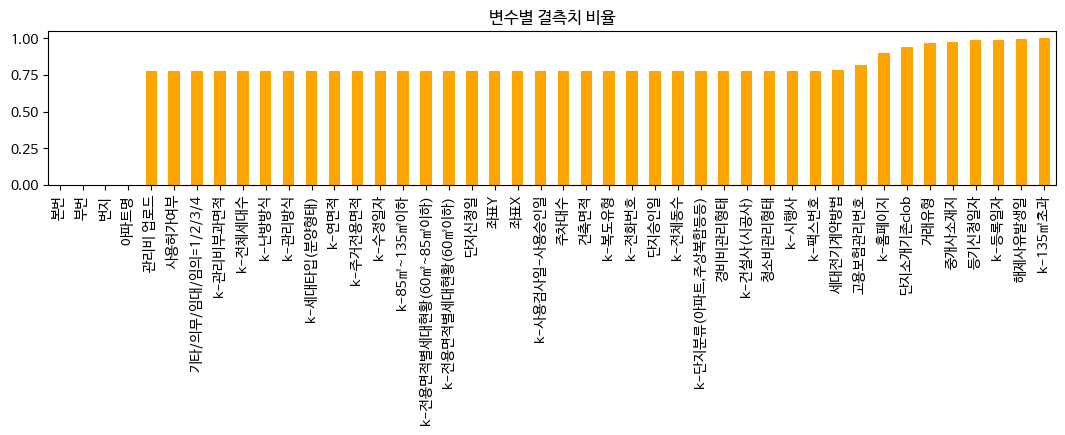

In [17]:
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

In [18]:
dt.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target'],
      dtype='object')

In [19]:
drop_columns = ["해제사유발생일", "기타/의무/임대/임의=1/2/3/4", 'k-시행사', '거래유형', '등기신청일자', '단지소개기존clob','k-전화번호', 'k-팩스번호', "중개사소재지", 'k-홈페이지', 'k-사용검사일-사용승인일','k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',  '사용허가여부', '관리비 업로드', '단지승인일', '단지신청일',]

In [20]:
concat_select = concat.drop(drop_columns, axis=1)

In [21]:
concat_select.isnull().sum()  

시군구                             0
번지                            225
본번                             75
부번                             75
아파트명                         2126
전용면적                            0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
k-단지분류(아파트,주상복합등등)         870691
k-세대타입(분양형태)               869563
k-관리방식                     869563
k-복도유형                     869890
k-난방방식                     869563
k-전체동수                     870630
k-전체세대수                    869563
k-건설사(시공사)                 871058
k-연면적                      869563
k-주거전용면적                   869608
k-관리비부과면적                  869563
k-전용면적별세대현황(60㎡이하)         869608
k-전용면적별세대현황(60㎡~85㎡이하)     869608
k-85㎡~135㎡이하               869608
k-135㎡초과                  1118495
건축면적                       869714
주차대수                       869714
좌표X                        869670
좌표Y           

In [22]:
# 범주형이므로
concat_select['본번'] = concat_select['본번'].astype('str')
concat_select['부번'] = concat_select['부번'].astype('str')

In [23]:
# 시군구를 시 - 구 - 동으로 분리

concat_select[["시", "구", "동"]] = concat_select["시군구"].str.split(' ', expand=True)

In [24]:
concat_select = concat_select.drop(["시군구"], axis=1)
concat_select.head(3)

,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,건축면적,주차대수,좌표X,좌표Y,target,is_test,시,구,동
0,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,언주로 3,아파트,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,4858.0,262.0,127.05721,37.476763,124000,0,서울특별시,강남구,개포동
1,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,언주로 3,아파트,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,4858.0,262.0,127.05721,37.476763,123500,0,서울특별시,강남구,개포동
2,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,언주로 3,아파트,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,4858.0,262.0,127.05721,37.476763,91500,0,서울특별시,강남구,개포동


In [25]:
concat_select.head()

,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,건축면적,주차대수,좌표X,좌표Y,target,is_test,시,구,동
0,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,언주로 3,아파트,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,4858.0,262.0,127.05721,37.476763,124000,0,서울특별시,강남구,개포동
1,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,언주로 3,아파트,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,4858.0,262.0,127.05721,37.476763,123500,0,서울특별시,강남구,개포동
2,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,언주로 3,아파트,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,4858.0,262.0,127.05721,37.476763,91500,0,서울특별시,강남구,개포동
3,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,언주로 3,아파트,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,4858.0,262.0,127.05721,37.476763,130000,0,서울특별시,강남구,개포동
4,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,언주로 3,아파트,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,4858.0,262.0,127.05721,37.476763,117000,0,서울특별시,강남구,개포동


In [26]:
#범주형은 따로 채우지 않는 이상 확인이 불가능하므로 NULL로 처리
continuous_columns = []
categorical_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'is_test']
범주형 변수: ['번지', '본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', '시', '구', '동']


In [27]:
concat_select[categorical_columns] = concat_select[categorical_columns].fillna('NULL')
concat_select.isnull().sum()

번지                              0
본번                              0
부번                              0
아파트명                            0
전용면적                            0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
k-단지분류(아파트,주상복합등등)              0
k-세대타입(분양형태)                    0
k-관리방식                          0
k-복도유형                          0
k-난방방식                          0
k-전체동수                     870630
k-전체세대수                    869563
k-건설사(시공사)                      0
k-연면적                      869563
k-주거전용면적                   869608
k-관리비부과면적                  869563
k-전용면적별세대현황(60㎡이하)         869608
k-전용면적별세대현황(60㎡~85㎡이하)     869608
k-85㎡~135㎡이하               869608
k-135㎡초과                  1118495
건축면적                       869714
주차대수                       869714
좌표X                        869670
좌표Y                        869670
target        

# 이상치
1. 주차대수 계산하기
-https://www.law.go.kr/%EB%B2%95%EB%A0%B9/%EC%A3%BC%ED%83%9D%EA%B1%B4%EC%84%A4%EA%B8%B0%EC%A4%80%20%EB%93%B1%EC%97%90%20%EA%B4%80%ED%95%9C%20%EA%B7%9C%EC%A0%95/%EC%A0%9C27%EC%A1%B0
1. 연면적 분포
2. 주거전용면적 분포
3. 관리비 부과면적 분포
4. 전용면적별세대현황 분포


주택단지에는 주택의 전용면적의 합계를 기준으로 하여 다음 표에서 정하는 면적당 대수의 비율로 산정한 주차대수 이상의 주차장을 설치하되, 세대당 주차대수가 1대(세대당 전용면적이 60제곱미터 이하인 경우에는 0.7대)이상이 되도록 해야 한다. 다만, 지역별 차량보유율 등을 고려하여 설치기준의 5분의 1(세대당 전용면적이 60제곱미터 이하인 경우에는 2분의 1)의 범위에서 특별시ㆍ광역시ㆍ특별자치시ㆍ특별자치도(관할 구역에 지방자치단체인 시ㆍ군이 없는 특별자치도를 말한다)ㆍ시ㆍ군 또는 자치구의 조례로 강화하여 정할 수 있다.

In [28]:
def number_of_parkinglot(num_of_current_parking, num_under_60, num_upper_60 ):
    total = 0
    if num_of_current_parking < 10:
        total = num_under_60 * 0.7 + num_upper_60 * 1
        return total
    else:
        return num_of_current_parking


In [29]:
concat_select["주차대수"] = concat_select.apply(
    lambda row: number_of_parkinglot(
        row['주차대수'], 
        row['k-전용면적별세대현황(60㎡이하)'], 
        row['k-전용면적별세대현황(60㎡~85㎡이하)']+ row["k-85㎡~135㎡이하"] + row['k-135㎡초과']
    ), 
    axis=1
)

In [32]:
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(249259, 33) (869563, 33)


In [33]:
dt_test.head(1)

,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,건축면적,주차대수,좌표X,좌표Y,target,시,구,동
975,189,189.0,0.0,개포주공4단지,50.39,201801,25,1,1982,삼성로 14,NULL,NULL,NULL,NULL,NULL,NaN,NaN,NULL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,134000,서울특별시,강남구,개포동


In [35]:
dt_test.shape

(869563, 33)

In [34]:
dt_test.isna().sum()

번지                             0
본번                             0
부번                             0
아파트명                           0
전용면적                           0
계약년월                           0
계약일                            0
층                              0
건축년도                           0
도로명                            0
k-단지분류(아파트,주상복합등등)             0
k-세대타입(분양형태)                   0
k-관리방식                         0
k-복도유형                         0
k-난방방식                         0
k-전체동수                    869563
k-전체세대수                   869563
k-건설사(시공사)                     0
k-연면적                     869563
k-주거전용면적                  869563
k-관리비부과면적                 869563
k-전용면적별세대현황(60㎡이하)        869563
k-전용면적별세대현황(60㎡~85㎡이하)    869563
k-85㎡~135㎡이하              869563
k-135㎡초과                  869563
건축면적                      869563
주차대수                      869563
좌표X                       869563
좌표Y                       869563
target                         0
시         

# 인코딩

In [244]:
continuous_columns = []
categorical_columns = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', '건축면적', '주차대수', '좌표X', '좌표Y', 'target']
범주형 변수: ['번지', '본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', '시', '구', '동']


- 아파트명, 'k-건설사(시공사)' 는 Label Encoding
- 이외에는 One-hotEncoding

In [247]:
label_encoders = {}

label_columns = ["아파트명", 'k-건설사(시공사)']

# Implement Label Encoding
for col in tqdm( label_columns ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|██████████| 2/2 [00:00<00:00, 13.73it/s]


In [248]:
dt_train.head(1)

,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,건축면적,주차대수,좌표X,좌표Y,target,시,구,동
0,658-1,658.0,1.0,56,79.97,201712,8,3,1987,언주로 3,아파트,분양,자치관리,계단식,개별난방,8.0,270.0,235,22637.0,20204.0,22637.0,20.0,250.0,0.0,0.0,4858.0,8,127.05721,37.476763,124000,서울특별시,강남구,개포동


In [254]:
dt_train["아파트명"].isnull().sum()

173511

In [253]:
one_hot_columns = [col for col in categorical_columns if col not in label_columns]

one_hot_encoders = {}

for col in tqdm(one_hot_columns):
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
    
    # 훈련 데이터로 fit
    ohe.fit(dt_train[[col]])
    
    # 훈련 데이터 인코딩
    encoded_train = ohe.transform(dt_train[[col]])
    dt_train_encoded = pd.DataFrame(encoded_train, columns=ohe.get_feature_names_out([col]))
    
    # 원본 데이터와 인코딩된 데이터를 병합
    dt_train = dt_train.drop(columns=[col])
    dt_train = pd.concat([dt_train, dt_train_encoded], axis=1)
    
    # 테스트 데이터 인코딩
    encoded_test = ohe.transform(dt_test[[col]])
    dt_test_encoded = pd.DataFrame(encoded_test, columns=ohe.get_feature_names_out([col]))
    
    # 원본 데이터와 인코딩된 데이터를 병합
    dt_test = dt_test.drop(columns=[col])
    dt_test = pd.concat([dt_test, dt_test_encoded], axis=1)
    
    # OneHotEncoder 객체 저장
    one_hot_encoders[col] = ohe



  0%|          | 0/12 [00:02<?, ?it/s]


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.